# Image segmentation

Extend your ResNet18 implementation to include a segmentation capabilities. The simplest extension of a backbone network is to simply generate the predictions at the last convolutional feature layer and then upsample them to fit the input image dimensions as described in https://arxiv.org/pdf/1411.4038.pdf (FCN-32s). 

For this exercise you will be using the following dataset: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge - You don't have to download it from kaggle as it is already hosted on drive (the script to download it is a few cells down).

For this task, implement the FCN-32s (https://arxiv.org/pdf/1411.4038.pdf), however this is one of the first and simplest fully convolutional segmentation networks and the results will be coarse. You can optionally extend your network with more complex segmentation heads.

A few network architecture that you can optionally implement to improve the results:
- the full FCN network described in https://arxiv.org/pdf/1411.4038.pdf 
- PSP-Net https://arxiv.org/pdf/1612.01105.pdf
- DeeplabV3 https://arxiv.org/pdf/1706.05587.pdf 


Additionally, implement the U-Net architecture https://arxiv.org/pdf/1505.04597.pdf and use it as a segmentation network. Compare it to your FCN-32s implementation.



## Network implementation

In [1]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, input_size, output_size, stride = 1, downsample = None):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm2d(output_size)

        self.conv2 = nn.Conv2d(output_size, output_size, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(output_size)

        self.relu = nn.ReLU()
        self.downsample = downsample

    
    def forward(self, x):
        x0 = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample:
            x0 = self.downsample(x0)

        x += x0
        x = self.relu(x)

        return x


class ResNet18FCN(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 13):
        super(ResNet18FCN, self).__init__()
        # Extend your implementation of ResNet18 and turn it into a segmentation network.
        # Add a segmentation head as described in https://arxiv.org/pdf/1411.4038.pdf
        # The simplest possible extension is to simply generate predictions at the 
        # last convolutional feature map and upsample the result.

        # the dataset has 13 possible classes 
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential(Block(64, 64), Block(64, 64))
        self.layer2 = nn.Sequential(Block(64, 128, stride = 2, downsample = self.downsample(64, 128)), Block(128, 128))
        self.layer3 = nn.Sequential(Block(128, 256, stride = 2, downsample = self.downsample(128, 256)), Block(256, 256))
        self.layer4 = nn.Sequential(Block(256, 512, stride = 2, downsample = self.downsample(256, 512)), Block(512, 512))

        # Changing the last fc layer to upsample (transpose convolution) layer for semantic segmentation
        self.deconv = nn.ConvTranspose2d(512, out_channels, kernel_size=32, stride=32, padding=0, output_padding=0)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
      
        x = self.deconv(x)
        
        return x


    def downsample(self, input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_size)
          )


class ConvBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(output_size)

        self.conv2 = nn.Conv2d(output_size, output_size, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(output_size)

        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 13):
        super(UNet, self).__init__()
        # define the neural network blocks for UNet
        # The implementation details of the network are listed in the paper: https://arxiv.org/pdf/1505.04597.pdf

        # Encoder
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.maxpool = nn.MaxPool2d((2, 2))

        self.conv = ConvBlock(512, 1024)

        # Decoder
        self.conv_T1 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2, padding = 0)
        self.dconv1 = ConvBlock(512*2, 512)
        self.conv_T2 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2, padding = 0)
        self.dconv2 = ConvBlock(256*2, 256)
        self.conv_T3 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 0)
        self.dconv3 = ConvBlock(128*2, 128)
        self.conv_T4 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0)
        self.dconv4 = ConvBlock(64*2, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size = 1, padding = 0)

        
    def forward(self, x):
        s1 = self.conv1(x)
        p1 = self.maxpool(s1)
        s2 = self.conv2(p1)
        p2 = self.maxpool(s2)
        s3 = self.conv3(p2)
        p3 = self.maxpool(s3)
        s4 = self.conv4(p3)
        p4 = self.maxpool(s4)

        b = self.conv(p4)

        d1 = self.conv_T1(b)
        d1 = torch.cat([d1, s4], axis = 1)
        d1 = self.dconv1(d1)
        d2 = self.conv_T2(d1)
        d2 = torch.cat([d2, s3], axis = 1)
        d2 = self.dconv2(d2)
        d3 = self.conv_T3(d2)
        d3 = torch.cat([d3, s2], axis = 1)
        d3 = self.dconv3(d3)
        d4 = self.conv_T4(d3)
        d4 = torch.cat([d4, s1], axis = 1)
        d4 = self.dconv4(d4)

        outputs = self.output(d4)
        return outputs

##Download the dataset
Download a part of the Lyft self driving dataset split into training and validation sets - https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge 


The dataset contains 13 classes:
0 - unlabeled,
1 - building,
2 - fence,
3 - other
4 - pedestrian,
5 - pole
6 - road line
7 - road
8 - sidewalk
9 - vegetation
10 - car
11 - wall
12 - traffic sign






In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

!unzip -q gdrive/MyDrive/data/seg_data.zip -d ./data/

Mounted at /content/gdrive


In [3]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM
!rm -r data
!mkdir data
!unzip -q seg_data.zip -d ./data/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM 

rm: cannot re

## Data loader

In [7]:
from torch.utils.data import Dataset
import glob
import cv2
import numpy as np

class SegmentationDataset(Dataset):

    def __init__(self, train=True):
        dataset_path = "./data/seg_data/" + ("train" if train else "test")
        self.images = sorted(glob.glob(dataset_path+"/*/*/CameraRGB/*.png"))
        self.masks = sorted(glob.glob(dataset_path+"/*/*/CameraSeg/*.png"))
        self.resize_shape = (320, 416)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path, mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,2]

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        mask = cv2.resize(mask, dsize=(self.resize_shape[1], self.resize_shape[0]))
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        mask = np.array(mask).reshape((image.shape[0], image.shape[1], 1))

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        return image, mask

    def __getitem__(self, idx):
        image, mask = self.transform_image(self.images[idx], self.masks[idx])
        sample = {'image': image, "mask": mask, 'idx': idx}

        return sample

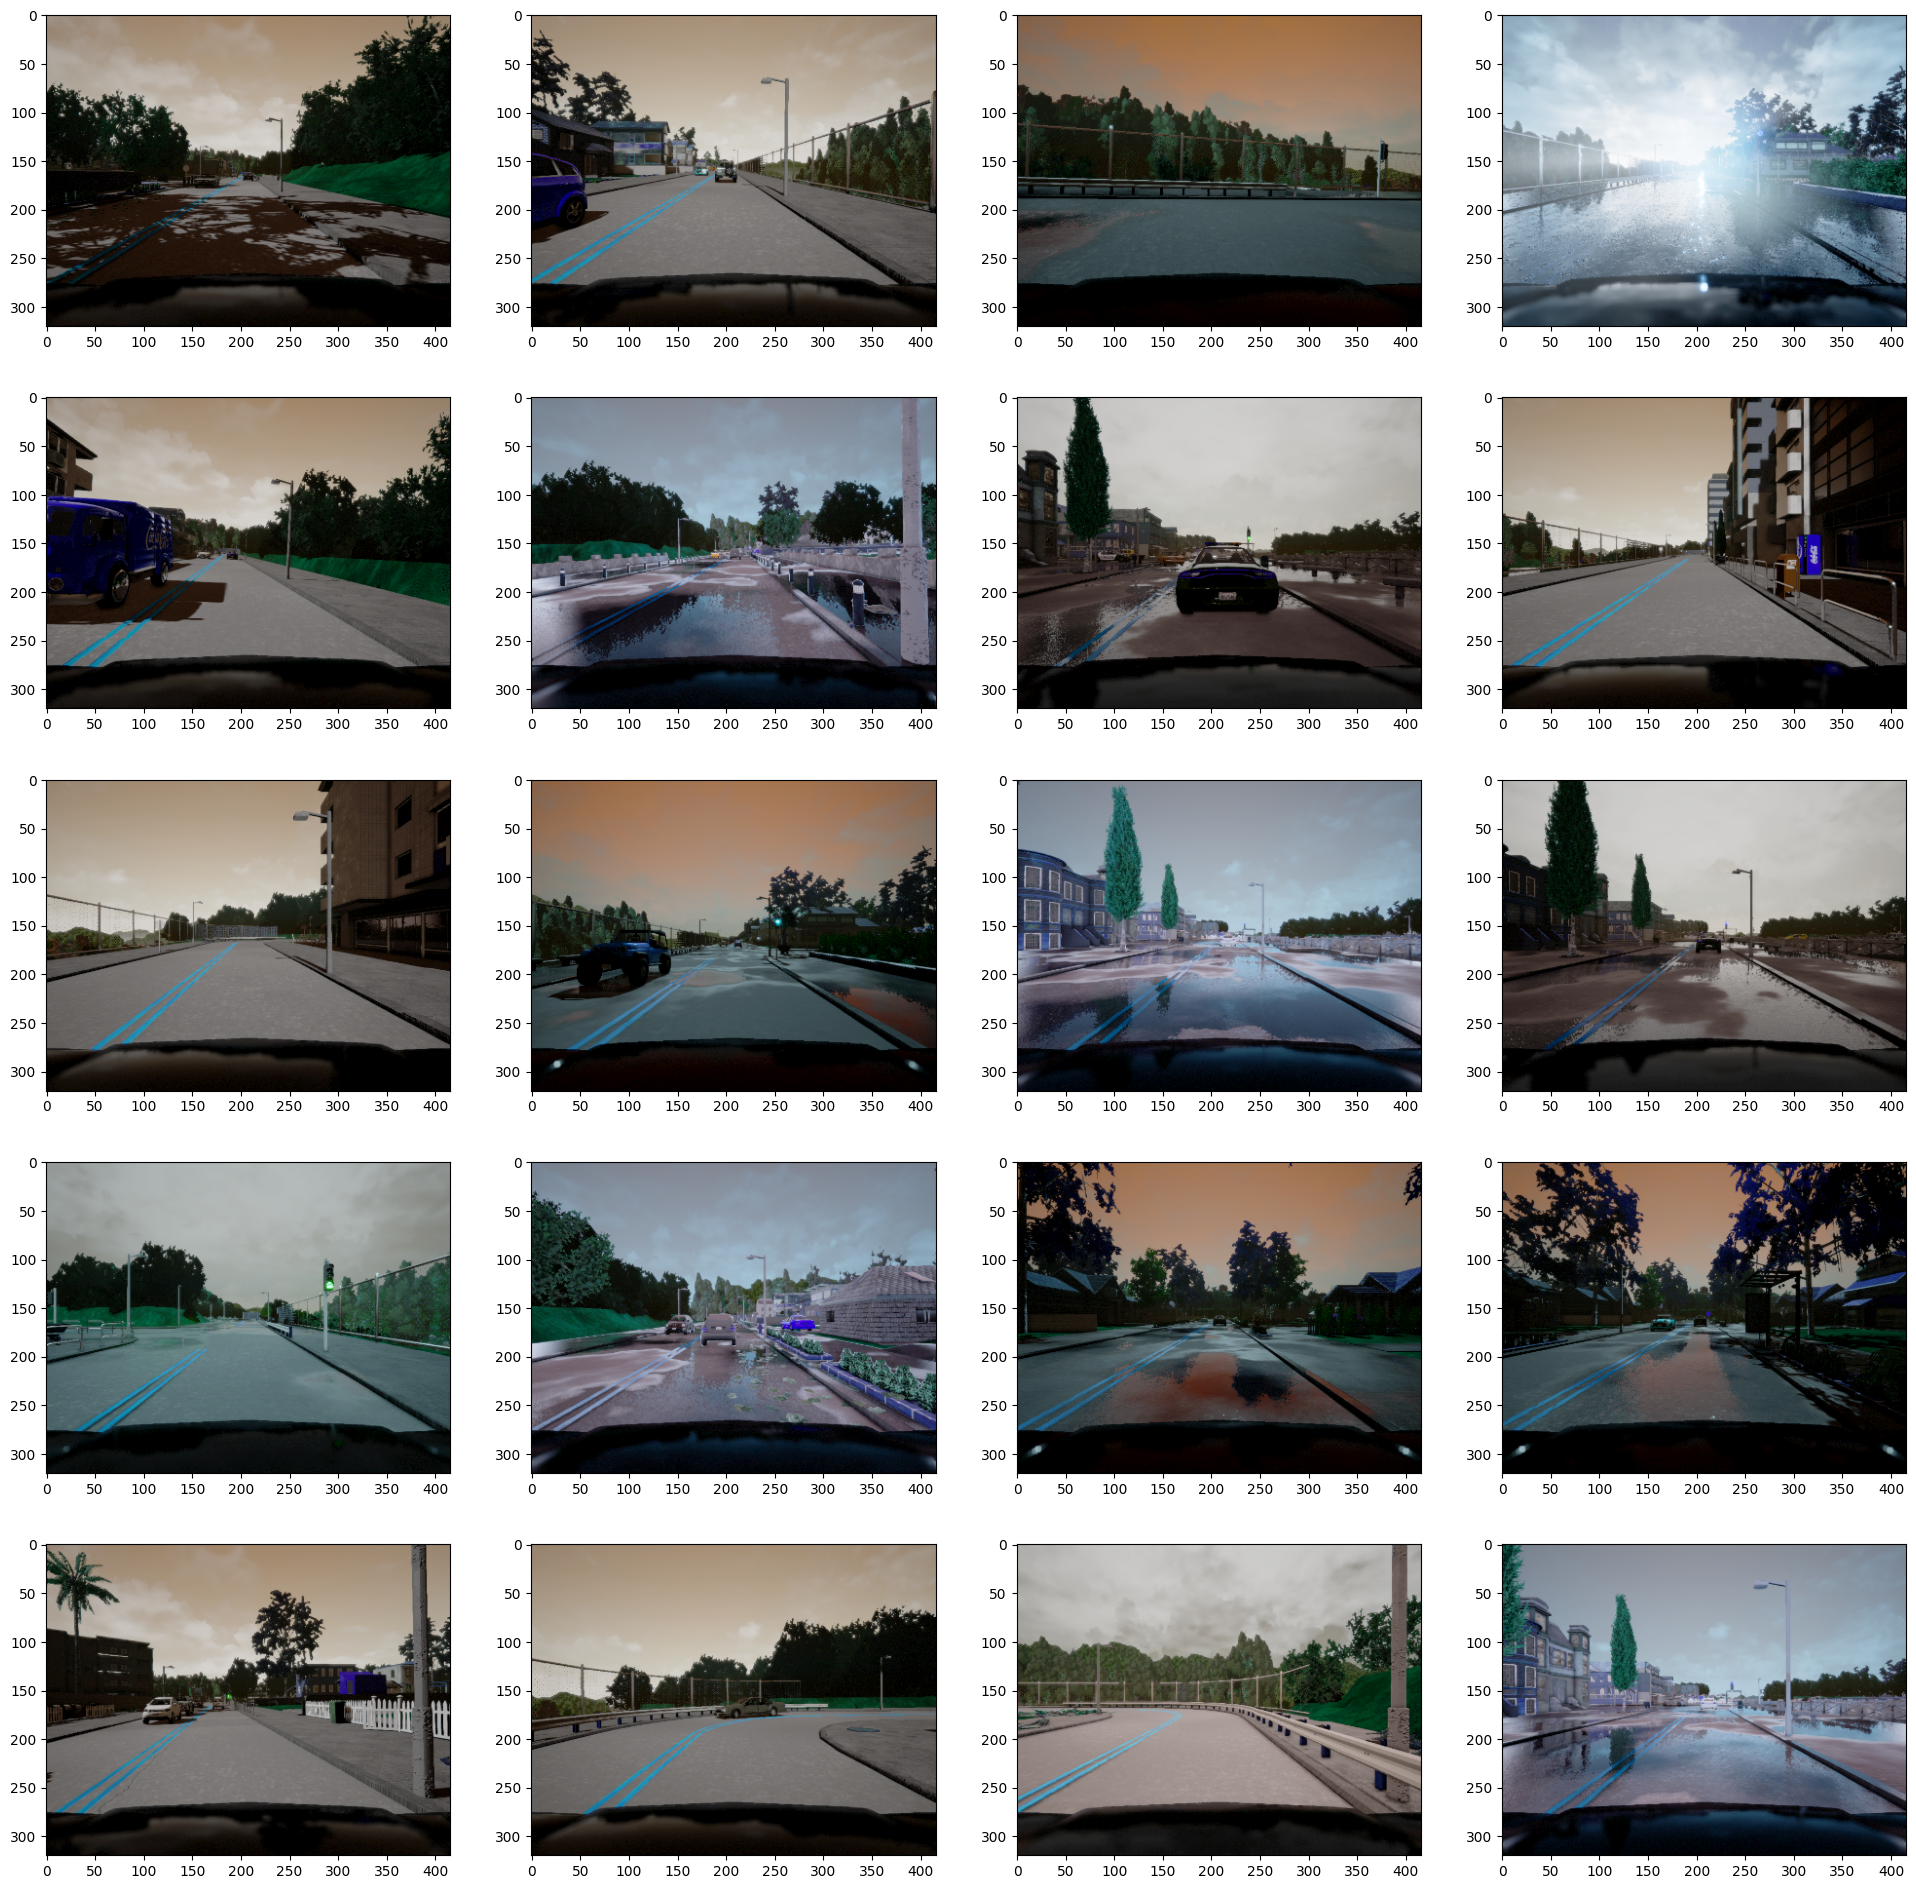

In [8]:
import torch
from tqdm.notebook import tqdm

trainset = SegmentationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = SegmentationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5
for i in range(rows*columns):
  data = trainset[np.random.randint(len(trainset))]
  input = data["image"]
  label = data["mask"]
  img = input.transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
plt.show()



In [9]:
import torch.optim as optim

def train_model(model):
    net = model(in_channels=3, out_channels=13)
    net.cuda()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    epochs=2
    for epoch in range(epochs):  # loop over the dataset multiple times
        with tqdm(total=len(trainset), desc =str(epoch+1)+"/"+str(epochs), miniters=int(50),unit='img') as prog_bar:
          for i, data in enumerate(trainloader, 0):
              # get the inputs; data is a list of [inputs, labels]
              inputs = data["image"]
              labels = data["mask"]
              inputs = inputs.cuda()
              labels = labels.cuda()

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              outputs = net(inputs)
              loss = criterion(outputs, labels[:,0,:,:].long())
              loss.backward()
              optimizer.step()

              prog_bar.set_postfix(**{'loss': np.round(loss.data.cpu().detach().numpy(),5)})
              prog_bar.update(4)

    return net

In [10]:
resnet18fcn = train_model(ResNet18FCN)

1/2:   0%|          | 0/4000 [00:00<?, ?img/s]

2/2:   0%|          | 0/4000 [00:00<?, ?img/s]

In [11]:
unet = train_model(UNet)

1/2:   0%|          | 0/4000 [00:00<?, ?img/s]

2/2:   0%|          | 0/4000 [00:00<?, ?img/s]

## Evaluate on the test set:

Implement the evaluation on the test set. Use the mean IOU metric to evaluate the result. - https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation 



In [12]:
def iou_score(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    IoUs = []
    for cls in np.unique(y_true):
        y_true_mask = y_true == cls
        y_pred_mask = y_pred == cls

        Intersection = y_pred_mask & y_true_mask # and
        Union = y_pred_mask | y_true_mask        # or

        IoU_class = np.sum(Intersection) / np.sum(Union)
        IoUs.append(IoU_class)
    
    return np.mean(IoUs)


In [13]:
def get_gtNpred(net, testset):
    ground_truth_masks = []
    predicted_masks = []

    for i in tqdm(range(len(testset))):
        batch = testset[i]
        img = batch['image']
        labels = batch['mask']
        img_tensor = torch.from_numpy(img).cuda()
        img_tensor = img_tensor.unsqueeze(0)
        outputs = net(img_tensor)
        out_image = outputs[0,:,:,:].detach().cpu().numpy()
        seg_mask = np.argmax(out_image,axis=0)
        
        ground_truth_masks.append(labels[0,:,:])
        predicted_masks.append(seg_mask)
    
    return ground_truth_masks, predicted_masks

In [14]:
gt1, pred1 = get_gtNpred(resnet18fcn, testset)
gt2, pred2 = get_gtNpred(unet, testset)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
from sklearn.metrics import jaccard_score

In [16]:
print("Weighted jaccard score (ResNet18fcn):", np.mean([jaccard_score(pred1[i].flatten(), gt1[i].flatten(), average = 'weighted') for i in tqdm(range(len(pred1)))]))
print("Weighted jaccard score (UNet):", np.mean([jaccard_score(pred2[i].flatten(), gt2[i].flatten(), average = 'weighted') for i in tqdm(range(len(pred2)))]))

meanIOU_resnet18fcn = np.mean([iou_score(pred1[i].flatten(), gt1[i].flatten()) for i in tqdm(range(len(pred1)))])
meanIOU_unet = np.mean([iou_score(pred2[i].flatten(), gt2[i].flatten()) for i in tqdm(range(len(pred2)))])

  0%|          | 0/1000 [00:00<?, ?it/s]

Weighted jaccard score (ResNet18fcn): 0.8693242551346245


  0%|          | 0/1000 [00:00<?, ?it/s]

Weighted jaccard score (UNet): 0.8981109928498339


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
print("Average IoU score for ResNet18fcn:", meanIOU_resnet18fcn)
print("Average IoU score for UNet:", meanIOU_unet)

Average IoU score for ResNet18fcn: 0.45701804431900855
Average IoU score for UNet: 0.512718204239908


## Visualize the results

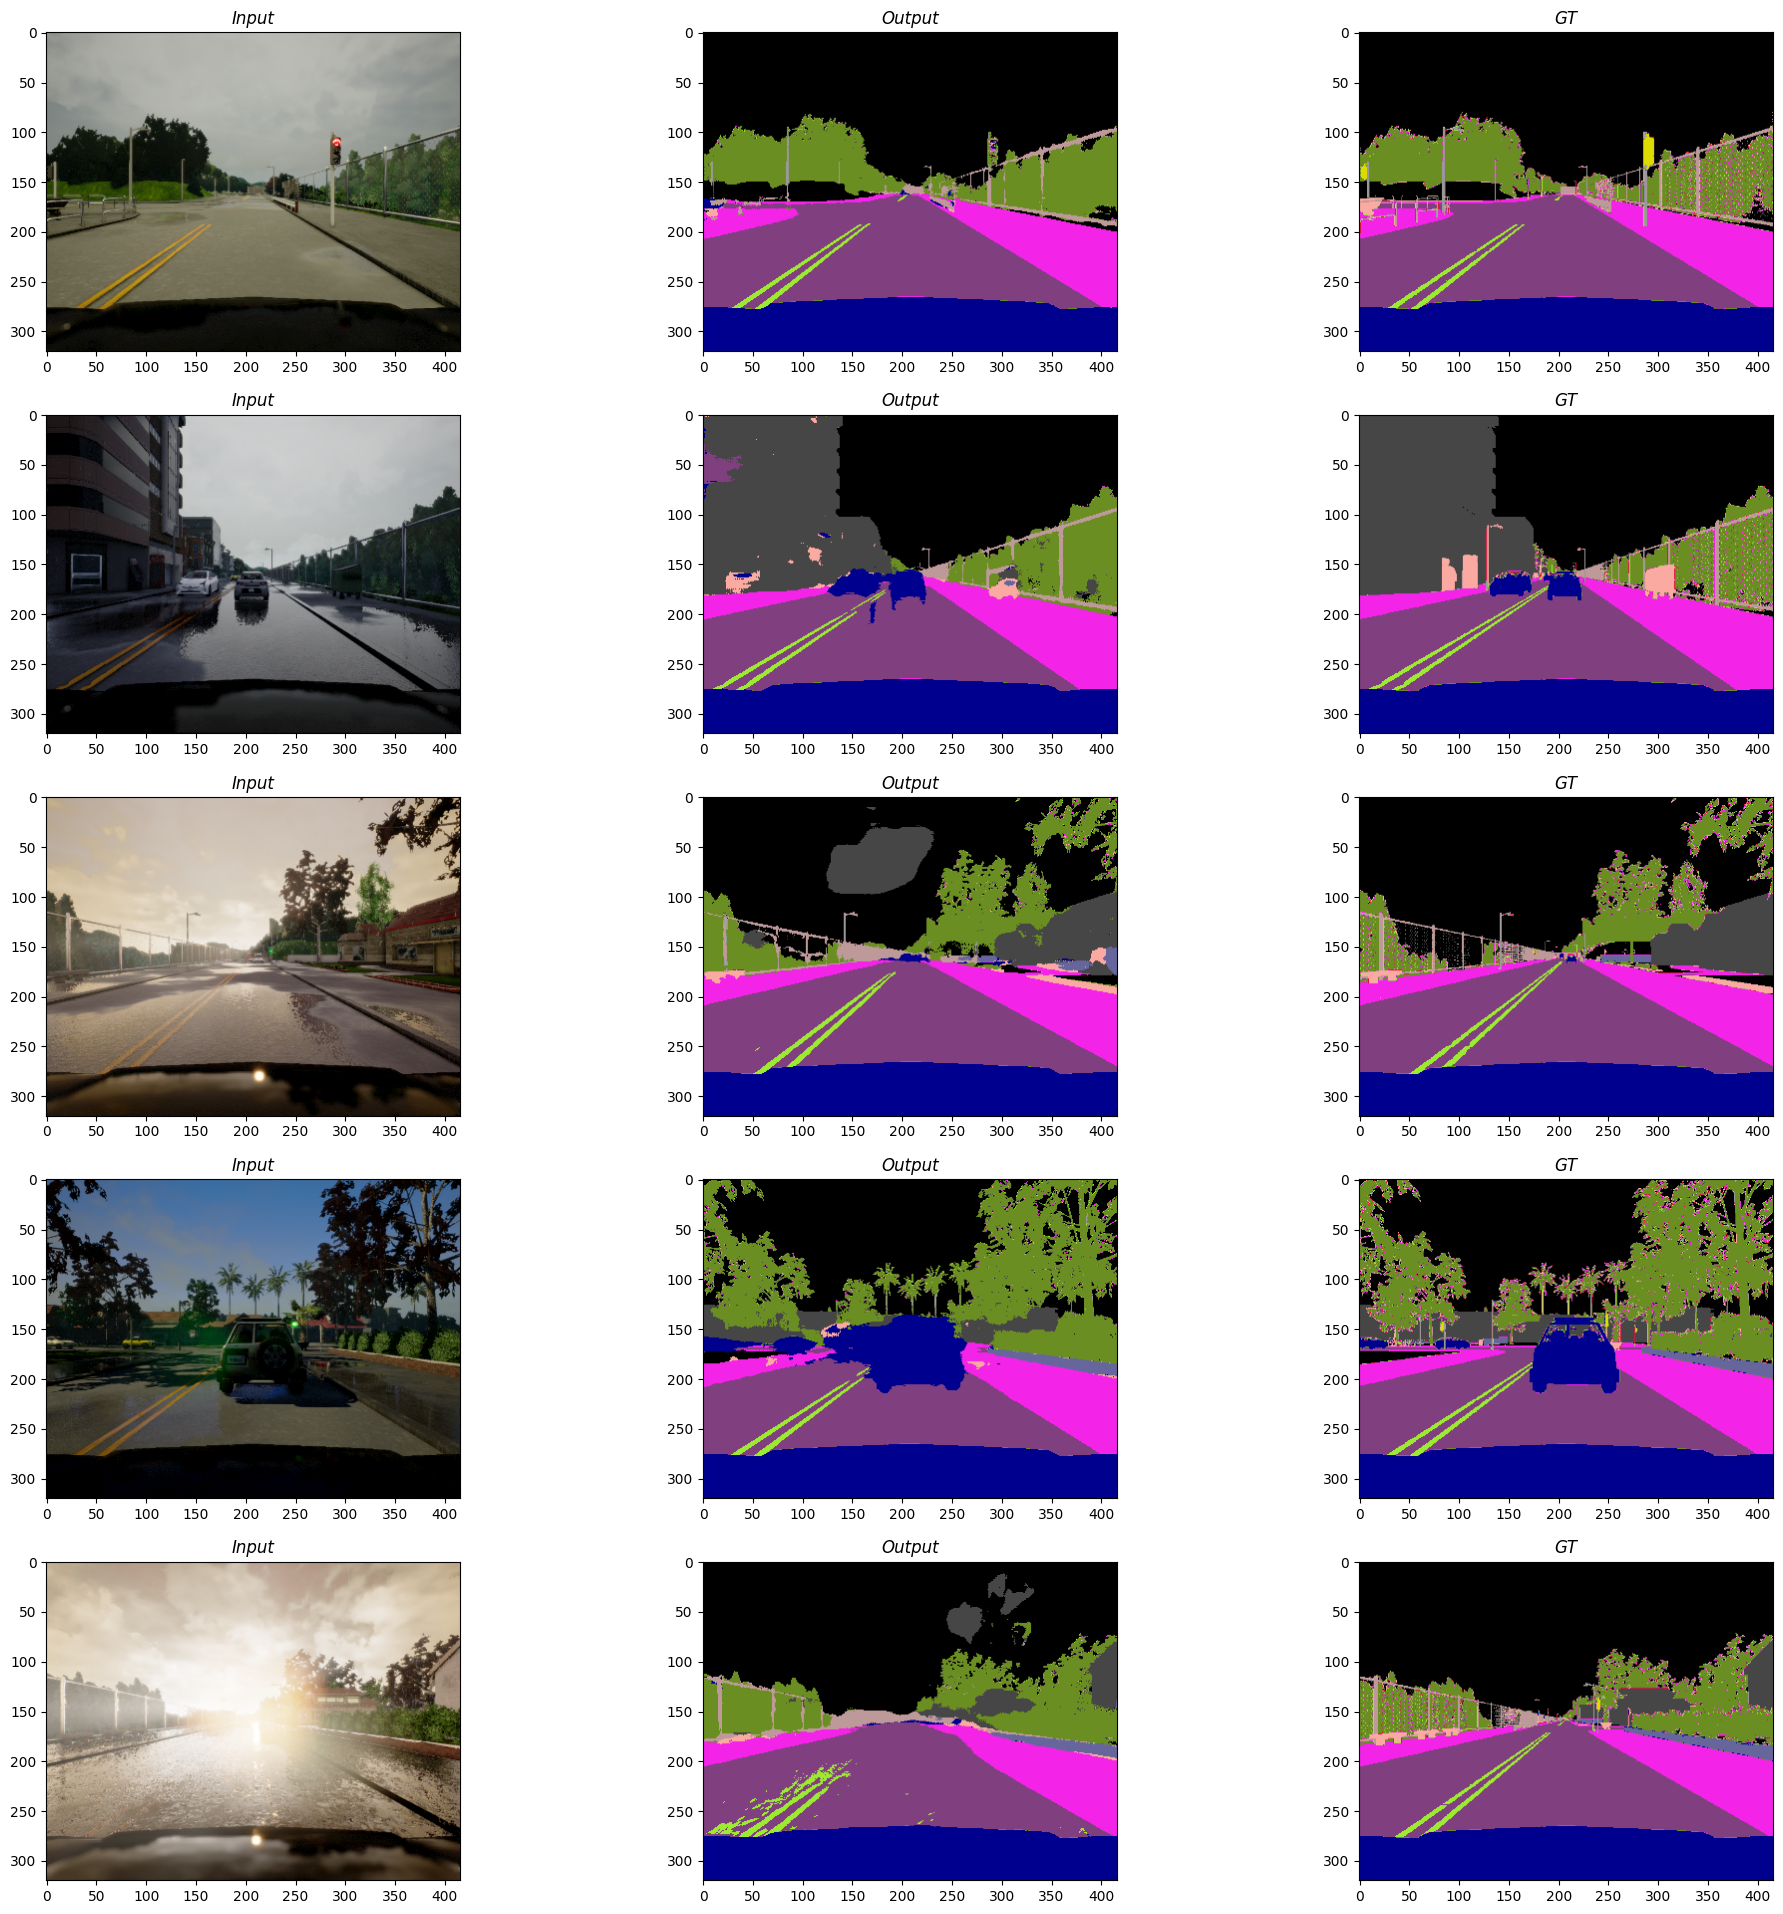

In [18]:
import matplotlib.pyplot as plt

label_colors = np.array([
[0,0,0], # unlabeled
[70,70,70], # building
[190,153,153], # fence
[250,170,160], # other
[220,20,60], # pedestrian
[153,153,153], # pole
[157,234,50], # road line
[128,64,128], # road
[244,35,232], # sidewalk
[107,142,35], # vegetation
[0,0,142], # car
[102,102,156], # wall
[220,220,0], # traffic sign
])

net = unet
net.eval()


fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[np.random.randint(len(testset))]
  img = batch['image']
  labels = batch['mask']
  img_tensor = torch.from_numpy(img).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy()
  seg_mask = np.argmax(out_image,axis=0)
  seg_mask_color = label_colors[seg_mask]
  gt_mask_color = label_colors[labels[0,:,:]]

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  labels = labels[0,:,:]
  ax = fig.add_subplot(rows, columns, i*columns+1)
  ax.set_title("Input", fontstyle='italic')
  plt.imshow(img)
  ax = fig.add_subplot(rows, columns, i*columns+2)
  ax.set_title("Output", fontstyle='italic')
  plt.imshow(seg_mask_color)
  ax = fig.add_subplot(rows, columns, i*columns+3)
  ax.set_title("GT", fontstyle='italic')
  plt.imshow(gt_mask_color)


plt.show()

750
0.42799897064186243 0.4769261878776421


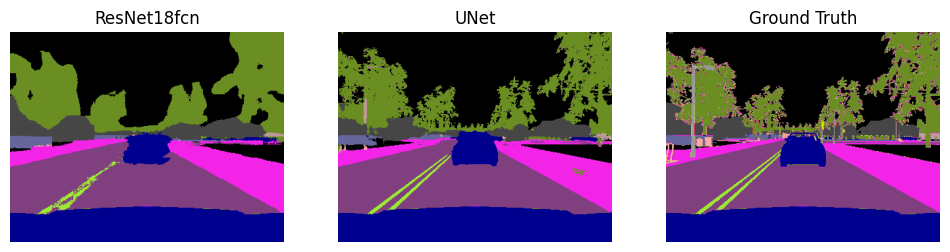

826
0.43337757989019016 0.504482607967302


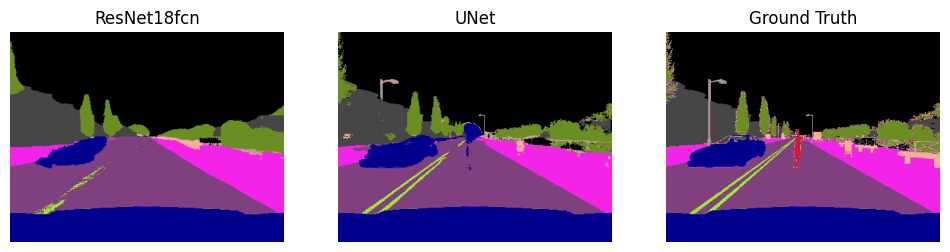

535
0.39397629189919986 0.4511416463727112


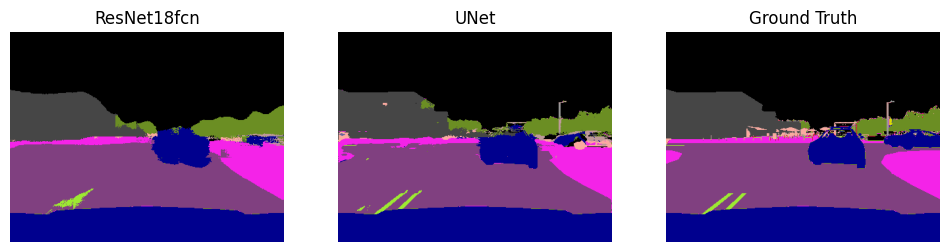

In [20]:
for _ in range(3):
    i = np.random.randint(len(pred1))
    print(i)
    fig, ax = plt.subplots(1, 3, figsize=(12, 12))
    print(iou_score(pred1[i], gt1[i]), iou_score(pred2[i], gt2[i]))

    ax[0].imshow(label_colors[pred1[i]])
    ax[0].set_title('ResNet18fcn')

    ax[1].imshow(label_colors[pred2[i]])
    ax[1].set_title('UNet')
    
    ax[2].imshow(label_colors[gt1[i]])
    ax[2].set_title('Ground Truth')

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()